This notebook is an example how `fastespy` modules are used to find pulses in the TES timline in fit them with a TES pulse shape. It is assumed that the data files have been converted from `root` to `numpy` files using, e.g., the script `convert_rootgraph2py.py`

### Imports

In [1]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import logging

#### Read in data and check that converted files exist

In [2]:
directory = '/Users/manuelmeyer/Python/TESdata/AlazarData/0729-20MHz/T20mK-I30uA/wibox-wligh-offset36mV/'


if not len(glob.glob(os.path.join(directory,"tes2_*.root"))) == len(glob.glob(os.path.join(directory,"tes2_*.npz"))):
    print("Error: convert files first!")

if not len(glob.glob(os.path.join(directory,"tes2*.root"))) == len(glob.glob(os.path.join(directory,"tes2*.npz"))):
    print("Error: convert files first!")

In [3]:
from fastespy.readpydata import readgraphpy

In [4]:
t,v,tin,vin = readgraphpy(directory, prefix = 'tes2', checkroot=True)

Reading file 1 of 3: /Users/manuelmeyer/Python/TESdata/AlazarData/0729-20MHz/T20mK-I30uA/wibox-wligh-offset36mV/tes2-out-001.npz
Reading file 2 of 3: /Users/manuelmeyer/Python/TESdata/AlazarData/0729-20MHz/T20mK-I30uA/wibox-wligh-offset36mV/tes2-out-002.npz
Reading file 3 of 3: /Users/manuelmeyer/Python/TESdata/AlazarData/0729-20MHz/T20mK-I30uA/wibox-wligh-offset36mV/tes2-out-003.npz


#### Set the mask from in voltage if "in" files exist

In [5]:
for i, vv in enumerate(vin):
    plt.hist(vv, bins = 100, density = True, alpha = 0.5)

The mask value is only applied if the files where found.

In [6]:
maskvalue = 0.035

In [7]:
m = []
if len(vin):
    for i, vv in enumerate(vin):
        m.append(vv > maskvalue)
else:
    for i, vv in enumerate(v):
        m.append(np.ones(vv.size, dtype = np.bool))

### Peak finding

In [8]:
from fastespy.analysis import derivative_filtered, build_trigger_windows, filter

Define the sampling frequency

In [9]:
fSample = 20.e6

Get the window of time line where biasing is correct (this does nothing if there were no "in" files)

In [10]:
idx = 0

where = np.where(m[idx] == False)
if len(where[0]):
    idxmax = where[0][0]
else:
    idxmax = m[idx].size
print (idxmax)
sli = slice(0,idxmax)

x = t[idx][m[idx]][sli]
y = v[idx][m[idx]][sli]

40000000


Compute the derivative:

In [11]:
dv,dvf = derivative_filtered(x, y, fSample, fmax = 1e6, norder = 3)

Plot an example 

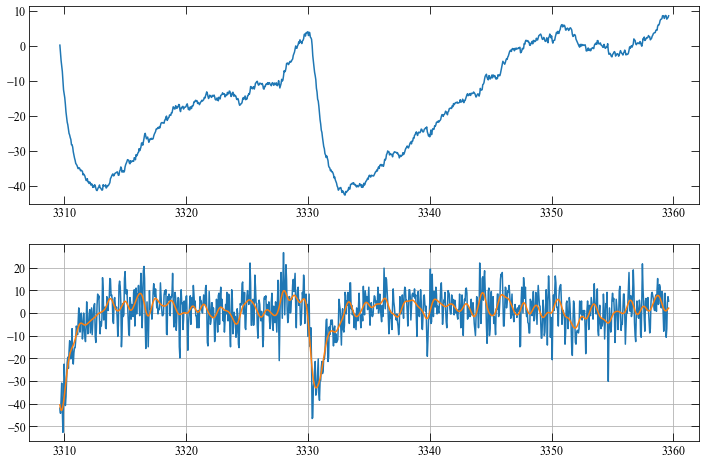

In [12]:
start = 66193
ps = slice(start,start + 1000)
plt.figure(figsize = (12,8))

ax = plt.subplot(211)
plt.plot(x[ps]* 1e6,y[ps]*1e3)

ax = plt.subplot(212)
plt.plot(x[ps] * 1e6,dv[ps] * 1e3 / 1e6)
plt.plot(x[ps] * 1e6,dvf[ps] * 1e3 / 1e6)
_ = plt.yticks(np.arange(-50,30,10))
plt.grid(True)

Find the trigger windows and extract time window oof -5$\mu$s and +30$\mu$s around trigger. Trigger threshold is set to $dV/dt = -40\,\mathrm{mV}\,\mu\mathrm{s}^{-1}$.

In [13]:
t0, t_trig, v_trig = build_trigger_windows(x,y, fSample = fSample, thr = -40.,
                                      tstepup=30., tsteplo=5., 
                                        fmax = 1e6, norder = 3)

130 trigger(s) found!


In [14]:
np.where(x == t0[0])

(array([66193]),)

Plot some trigger windows:

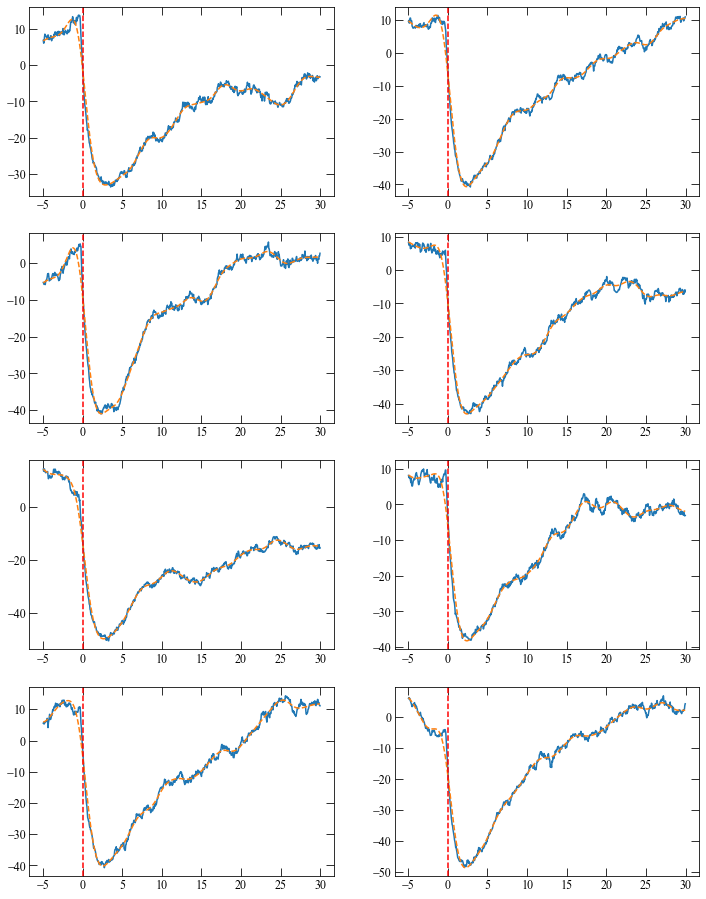

In [15]:
nwin = slice(13,21)


plt.figure(figsize = (6 * 2, (nwin.stop - nwin.start)*4 / 2))

for i, t in enumerate(t_trig[nwin]):
    
    ip = nwin.start + i
    
    ax = plt.subplot((nwin.stop - nwin.start) / 2,2,i+1)
    
    plt.plot((t - t0[ip]) * 1e6, v_trig[ip] * 1e3)
    plt.plot((t - t0[ip]) * 1e6, filter(v_trig[ip] * 1e3, norder = 3, fmax = 3e5, fSample = fSample), ls = '--')
    plt.axvline(0., ls = '--', color = 'r')

### Perform a fit 

In [16]:
from fastespy.fitting import TimeLine, FitTimeLine
from fastespy.analysis import init_logging

In [17]:
init_logging("INFO", color = True)

fitting.py: 648 --- INFO: fit took: 0.06398987770080566s
fitting.py: 649 --- INFO: Best AIC = 523.23 for 1 components
fitting.py: 657 --- INFO: best fit tr_000: 1.07341e+00 +/- 5.34949e-02
fitting.py: 657 --- INFO: best fit td_000: 9.72469e+00 +/- 2.59150e-01
fitting.py: 657 --- INFO: best fit c: 5.70940e+00 +/- 2.88843e-01
fitting.py: 657 --- INFO: best fit A_000: 4.33737e+01 +/- 4.10538e-01
fitting.py: 657 --- INFO: best fit t0_000: -1.91595e-01 +/- 2.68099e-02
fitting.py: 642 --- INFO: bad fit and all trigger times added, adding additional component


-0.25
1 trigger(s) found!
reduced chi2:  0.7395188367035296
1 trigger(s) found!


/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/fitting.py:565: HesseFailedWarning: HESSE Failed. Covariance and GlobalCC will not be available
  self._m.hesse()
fitting.py: 457 --- WARNING: Migrad did not converge, is above max edm. Increasing tol.
fitting.py: 462 --- INFO: New tolerance : 0.0004611746034507425
fitting.py: 474 --- INFO: Migrad status after second try: True
fitting.py: 648 --- INFO: fit took: 1.4698779582977295s
fitting.py: 649 --- INFO: Best AIC = 654.73 for 2 components
fitting.py: 657 --- INFO: best fit tr_000: 1.62932e+00 +/- 1.86974e-01
fitting.py: 657 --- INFO: best fit td_000: 1.62923e+00 +/- 1.86772e-01
fitting.py: 657 --- INFO: best fit c: 1.21909e+01 +/- 2.61499e-01
fitting.py: 657 --- INFO: best fit A_000: 2.40911e+01 +/- 1.05463e+00
fitting.py: 657 --- INFO: best fit t0_000: -1.82412e-01 +/- 4.40260e-02
fitting.py: 657 --- INFO: best fit t0_001: -4.68322e-01 +/- 7.74389e-02
fitting.py: 657 --- INFO: best fit td_001: 5.82650e+00 +/- 3.29366e-01
fitting.p

reduced chi2:  0.9228001639205822
1 trigger(s) found!
reduced chi2:  0.8221885491399138
1 trigger(s) found!


/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/fitting.py:80: RuntimeWarning: invalid value encountered in power
  xi = np.power(kwargs['td'] / kwargs['tr'], kwargs['td'] / (kwargs['tr'] - kwargs['td'])) \
/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/fitting.py:81: RuntimeWarning: invalid value encountered in power
  - np.power(kwargs['td'] / kwargs['tr'],kwargs['tr'] / (kwargs['tr'] - kwargs['td']))
/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/fitting.py:83: RuntimeWarning: invalid value encountered in greater
  m = t > kwargs['t0']
fitting.py: 642 --- INFO: bad fit and all trigger times added, adding additional component
/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/fitting.py:92: RuntimeWarning: invalid value encountered in subtract
  result[m] = kwargs['c'] - (exp_rise - exp_decay)[m] * kwargs['A'] / xi
fitting.py: 457 --- WARNING: Migrad did not converge, is above max edm. Increasing tol.
fitting.py: 462 --- INFO: New tolerance : 0.12799758215248774
fittin

reduced chi2:  5.344850449232984
1 trigger(s) found!


fitting.py: 642 --- INFO: bad fit and all trigger times added, adding additional component
fitting.py: 429 --- WARNING: *** migrad minimum not ok! Printing output of get_fmin
fitting.py: 432 --- WARNING: *** has_accurate_covar:	False
fitting.py: 434 --- WARNING: *** has_covariance:	True
fitting.py: 436 --- WARNING: *** has_made_posdef_covar:	False
fitting.py: 438 --- WARNING: *** has_posdef_covar:	False
fitting.py: 440 --- WARNING: *** has_reached_call_limit:	False
fitting.py: 442 --- WARNING: *** has_valid_parameters:	True
fitting.py: 444 --- WARNING: *** hesse_failed:	True
fitting.py: 446 --- WARNING: *** is_above_max_edm:	False
fitting.py: 448 --- WARNING: *** is_valid:	False


reduced chi2:  1.757967247204337
1 trigger(s) found!


fitting.py: 648 --- INFO: fit took: 0.06688690185546875s
fitting.py: 649 --- INFO: Best AIC = 446.70 for 1 components
fitting.py: 657 --- INFO: best fit tr_000: 1.57646e+00 +/- 6.62975e-02
fitting.py: 657 --- INFO: best fit td_000: 8.44136e+00 +/- 2.01405e-01
fitting.py: 657 --- INFO: best fit c: 3.03944e+00 +/- 2.58241e-01
fitting.py: 657 --- INFO: best fit A_000: 4.75029e+01 +/- 4.00731e-01
fitting.py: 657 --- INFO: best fit t0_000: -4.17032e-01 +/- 2.69773e-02
fitting.py: 642 --- INFO: bad fit and all trigger times added, adding additional component


reduced chi2:  1.230863917112967
1 trigger(s) found!
reduced chi2:  0.6292460105669837
1 trigger(s) found!


fitting.py: 642 --- INFO: bad fit and all trigger times added, adding additional component
fitting.py: 648 --- INFO: fit took: 20.854750394821167s
fitting.py: 649 --- INFO: Best AIC = 456.32 for 3 components
fitting.py: 657 --- INFO: best fit tr_000: 5.07453e+00 +/- 0.00000e+00
fitting.py: 657 --- INFO: best fit td_000: 5.07454e+00 +/- 0.00000e+00
fitting.py: 657 --- INFO: best fit c: 1.85972e+01 +/- 0.00000e+00
fitting.py: 657 --- INFO: best fit A_000: 4.70307e+01 +/- 0.00000e+00
fitting.py: 657 --- INFO: best fit t0_000: 7.26550e-01 +/- 0.00000e+00
fitting.py: 657 --- INFO: best fit t0_001: -3.09889e-01 +/- 0.00000e+00
fitting.py: 657 --- INFO: best fit td_001: 1.40798e+00 +/- 0.00000e+00
fitting.py: 657 --- INFO: best fit tr_001: 1.40798e+00 +/- 0.00000e+00
fitting.py: 657 --- INFO: best fit A_001: 3.91547e+01 +/- 0.00000e+00
fitting.py: 657 --- INFO: best fit t0_002: -4.94997e+00 +/- 0.00000e+00
fitting.py: 657 --- INFO: best fit td_002: 2.25319e+00 +/- 0.00000e+00
fitting.py: 657 

reduced chi2:  0.6272920392504018
1 trigger(s) found!
reduced chi2:  0.5859378889736382


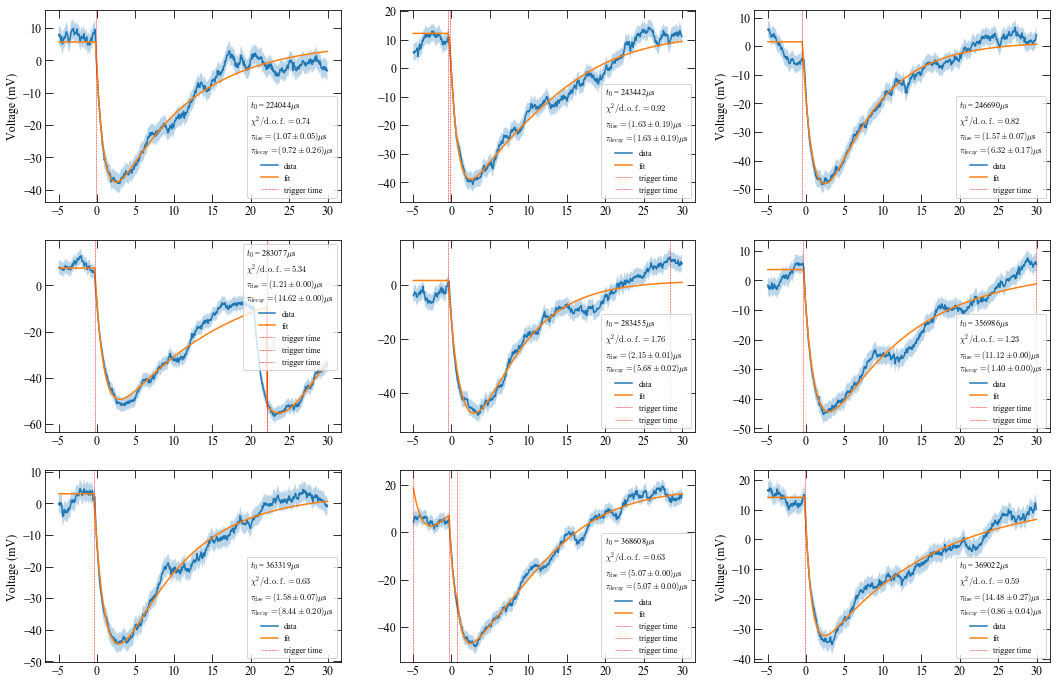

In [18]:
nperrow = 3

start = 18
nwin = slice(start, start + 3 * nperrow)

tr = 2.
td = 4.

xi = (td / tr)**(td / (tr - td)) - (td / tr)**(tr / (tr - td))

print (xi)

function = 'tesresponse'
#function = 'expflare'


plt.figure(figsize = (6 * nperrow, (nwin.stop - nwin.start)*4 / nperrow))


for i, t in enumerate(t_trig[nwin]):
    ax = plt.subplot((nwin.stop - nwin.start) / nperrow, nperrow, i+1)
    
    ip = i + nwin.start
    
    y = v_trig[ip] * 1e3  # convert to mV
    
    sli = slice(0,t.size,1)
    
    dy = np.full(y.size, 3.)
                 
    plt.plot((t - t0[ip])[sli] * 1e6, y[sli], ls = '-', label = 'data')
    plt.fill_between((t - t0[ip])[sli] * 1e6, (y - dy)[sli], y2 = (y + dy)[sli], 
                    alpha = 0.3)
                 
    ftl = FitTimeLine(t = (t[sli] - t0[ip]) * 1e6, 
                      v = y[sli], 
                      dv = dy[sli], fSample = fSample)
                     
    
    # set the initial conditions
    # trigger times are set automatically, no need to 
    # provide these initial conditions to function
    kwargs = {}
    kwargs['fix'] = dict()
    kwargs['islog'] = dict()

    if function == 'tesresponse':
        kwargs['pinit'] = dict(
                        #t0_000 = 0.,
                        tr_000 = tr,
                        td_000 = td,
                        c = ftl._v[0],
                        A_000 = np.abs(np.min(ftl.v))
                        )
    elif function == 'expflare':
        kwargs['pinit'] = dict(
                #t0_000 = 0.,
                tr_000 = 0.5,
                td_000 = 7.,
                c = 0.,
                A_000 = np.abs(np.min(ftl.v)) * 0.66
                ) 
    
    # set the limits for fitting
    kwargs['limits'] = dict(
                        t0_000 = [ftl.t.min(),ftl.t.max()],
                        tr_000 = [1e-5,1e2],
                        td_000 = [1e-5,1e2],
                        c = [-100.,100.],
                        A_000 = [1e-5, 1e3]
    )
    
    
    # perform the fit
    r = ftl.fit(tmin = None,
            tmax = None,
            function = 'tesresponse',
            minos = 1., parscan = 'none', dvdt_thr = -40.,
            **kwargs)
    
    # this is fitting function, define here for plotting
    func = TimeLine(numcomp = r['numcomp'], function = function)
    
    ax.plot((t - t0[ip]) * 1e6, func((t - t0[ip]) * 1e6, **r['fitarg']),
            label = 'fit')
    
    chi2dof = r['chi2'] / r['dof']
    string = "$t_0$ = {5:.0f}$\mu$s\n" \
                "$\chi^2 / \mathrm{{d.o.f.}} = {0:.2f}$\n$\\tau_\mathrm{{rise}} = ({1:.2f}\pm{2:.2f})\mu$s" \
                "\n$\\tau_\mathrm{{decay}} = ({3:.2f}\pm{4:.2f})\mu$s".format(chi2dof, 
                                                                          r['fitarg']['tr_000'],
                                                                          r['fitarg']['error_tr_000'],
                                                                          r['fitarg']['td_000'],
                                                                          r['fitarg']['error_td_000'],
                                                                              t0[ip] * 1e6)
    for i in range(r['numcomp']):
        ax.axvline(r['value']['t0_{0:03}'.format(i)],
                   ls = '--', color = 'r', lw = 0.5, label = 'trigger time')
    
    
    leg = ax.legend(title = string, fontsize = 'small')
    plt.setp(leg.get_title(), fontsize = 'small')
    print ("reduced chi2: ",chi2dof)
    if not i % nperrow:
        ax.set_ylabel("Voltage (mV)")
        
    if i >= (nwin.stop - nwin.start) - nperrow:
        ax.set_xlabel("Time ($\mu$s)")
        
plt.savefig("fit_testing.png", format = 'png', dpi = 150)